# HW 2 - Naive Bayes in Hadoop MR
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information`__

In the live sessions for week 2 and week 3 you got some practice designing and debugging Hadoop Streaming jobs. In this homework we'll use Hadoop MapReduce to implement your first parallelized machine learning algorithm: Naive Bayes. As you develop your implementation you'll test it on a small dataset that matches the 'Chinese Example' in the _Manning, Raghavan and Shutze_ reading for Week 2. For the main task in this assignment you'll be working with a small subset of the Enron Spam/Ham Corpus. By the end of this assignment you should be able to:
* __... describe__ the Naive Bayes algorithm including both training and inference.
* __... perform__ EDA on a corpus using Hadoop MR.
* __... implement__ parallelized Naive Bayes.
* __... constrast__ partial, unordered and total order sort and their implementations in Hadoop Streaming.
* __... explain__ how smoothing affects the bias and variance of a Multinomial Naive Bayes model.

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code.

------------------------

**Please, remember that you will use this Notebook as your working copy to prepare your answer, but you are expected to submit your final answer to Digital Campus for grading.**

------------------------


## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [ ]:
!hadoop version

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop/hadoop-streaming.jar"
HDFS_DIR = "/user/root/HW2"
HOME_DIR = "/media/notebooks/Assignments/HW2-HR"

In [4]:
%cd {HOME_DIR}

/media/notebooks/Assignments/HW2-HR


In [5]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [6]:
# data path
ENRON = "data/enronemail_1h.txt"

In [7]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -mkdir -p {HDFS_DIR}
!hdfs dfs -ls 

Found 2 items
drwxr-xr-x   - root hadoop          0 2023-06-07 01:52 HW2
drwxr-xr-x   - root hadoop          0 2023-06-07 00:57 demo3


# Question 1: Hadoop MapReduce Key Takeaways

This assignment will be the only one in which you use Hadoop Streaming to implement a distributed algorithm. The key reason we continue to teach Hadoop streaming is because of the way it forces the programmer to think carefully about what is happening under the hood when you parallelize a calculation. This question will briefly highlight some of the most important concepts that you need to understand about Hadoop Streaming and MapReduce before we move on to Spark next week.   

### Q1 Tasks:

* __a) Multiple Choice on Digital Campus:__ What "programming paradigm" is Hadoop MapReduce based on? Functional programming

* __b) Multiple Answers on Digital Campus:__ What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas? Pure functions, etc.

* __c) Short Essay on Digital Campus:__ What is the Hadoop Shuffle? When does it happen? Why is it potentially costly? Describe one specific thing we can we do to mitigate the cost associated with this stage of our Hadoop Streaming jobs.

<span style="color: red; font-size: 1.4em">ANSWER THIS</span>

* __d) Multiple Choice on Digital Campus:__ In Hadoop Streaming why do the input and output record format of a combiner script have to be the same? [__`HINT`__ What level of combining does the framework guarantee? what is the relationship between the record format your mapper emits and the format your reducer expects to receive?_]

Combiners are not guaranteed to be run, they are just an optimization, therefore the formats must be the same.

* __e) Multiple Choice on Digital Campus:__ To what extent can you control the level of parallelization of your Hadoop Streaming jobs? Please be specific.

You can use however many reduce and mapper tasks as nodes you have available or run in Uber mode (as little as 1).

* __f) Multiple Choice on Digital Campus:__ What change in the kind of computing resources available prompted the creation of parallel computation frameworks like Hadoop? 

Cloud computing? Something like that.


# Question 2: MapReduce Design Patterns 

In the last two live sessions and in your readings from Lin & Dyer you encountered a number of techniques for manipulating the logistics of a MapReduce implementation to ensure that the right information is available at the right time and location. In this question we'll review a few of the key techniques you learned.   

### Q2 Tasks:

* __a) Multiple Answers on Digital Campus:__ What are counters (in the context of Hadoop Streaming)? How are they useful? What kinds of counters does Hadoop provide for you? How do you create your own custom counter? 

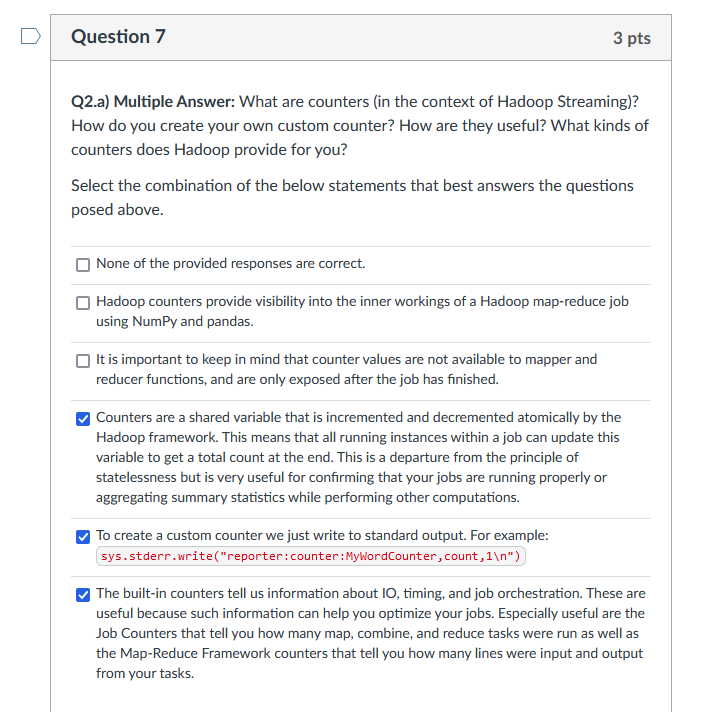

* __b) Multiple Choice on Digital Campus:__ What are composite keys? How are they useful? How are they related to the idea of custom partitioning?

=**i, ii, iii, iv**=

* __c) Multiple Choice on Digital Campus:__ What is the order inversion pattern? What problem does it help solve? How do we implement it? 


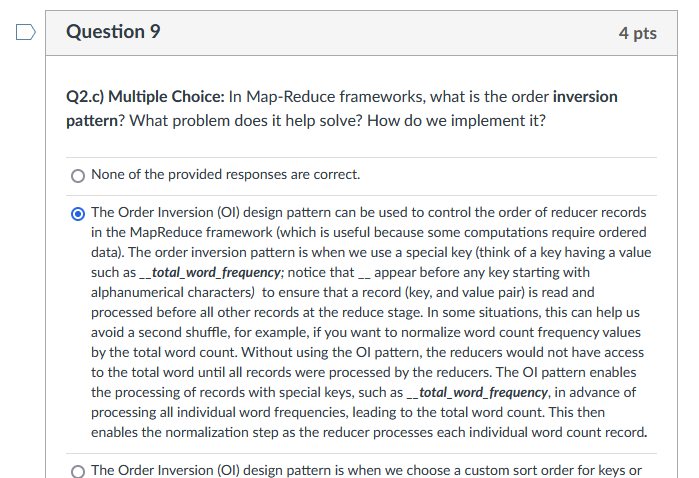

# Question 3: Understanding Total Order Sort

The key challenge in distributed computing is to break a problem into a set of sub-problems that can be performed without communicating with each other. Ideally, we should be able to define an arbitrary number of splits and still get the right result, but that is not always possible. Parallelization becomes particularly challenging when we need to make comparisons between records, for example when sorting. Total Order Sort allows us to order large datasets in a way that enables efficient retrieval of results. Before beginning this assignment, make sure you have read and understand the [Total Order Sort Notebook](https://github.com/UCB-w261/main/blob/main/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb) in GCS folder (__`/GCS/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb`__). You can skip the first two MRJob sections, but the rest of section III and all of section IV are **very** important (and apply to Hadoop Streaming) so make sure to read them closely. Feel free to read the Spark sections as well but you won't be responsible for that material until later in the course. To verify your understanding, answer the following questions.

### Q3 Tasks:

* __a) Short Essay on Digital Campus:__ What is the difference between a Partial Sort, an Unordered Total Sort, and a Total Order Sort? From the programmer's perspective, what does Total Order Sort allow us to do that we can't with Unordered Total? Why is this important with large datasets?

* __b) Multiple Choice on Digital Campus:__ Which phase of a MapReduce job is leveraged to implement Total Order Sort? Which default behaviors must be changed. Why must they be changed?

* __c) Short Essay on Digital Campus:__ Describe in words how to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort.  

* __d) Multiple Choice on Digital Campus:__ Explain why we need to use an inverse hash code function.

* __e) Multiple Choice on Digital Campus:__ Where does this function need to be located so that a Total Order Sort can be performed?


# About the Data
For the main task in this portion of the homework you will train a classifier to determine whether an email represents spam or not. You will train your Naive Bayes model on a 100 record subset of the Enron Spam/Ham corpus available in the HW2 data directory (__`HW2/data/enronemail_1h.txt`__).

__Source:__   
The original data included about 93,000 emails which were made public after the company's collapse. There have been a number raw and preprocessed versions of this corpus (including those available [here](http://www.aueb.gr/users/ion/data/enron-spam/index.html) and [here](http://www.aueb.gr/users/ion/publications.html)). The subset we will use is limited to emails from 6 Enron employees and a number of spam sources. It is part of [this data set](http://www.aueb.gr/users/ion/data/enron-spam/) which was created by researchers working on personalized Bayesian spam filters. Their original publication is [available here](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf). __`IMPORTANT!`__ _For this homework please limit your analysis to the 100 email subset which we provide. No need to download or run your analysis on any of the original datasets, those links are merely provided as context._

__Preprocessing:__  
For their work, Metsis et al. (the authors) appeared to have pre-processed the data, not only collapsing all text to lower-case, but additionally separating "words" by spaces, where "words" unfortunately include punctuation. As a concrete example, the sentence:  
>  `Hey Jon, I hope you don't get lost out there this weekend!`  

... would have been reduced by Metsis et al. to the form:  
> `hey jon , i hope you don ' t get lost out there this weekend !` 

... so we have reverted the data back toward its original state, removing spaces so that our sample sentence would now look like:
> `hey jon, i hope you don't get lost out there this weekend!`  

Thus we have at least preserved contractions and other higher-order lexical forms. However, one must be aware that this reversion is not complete, and that some object (specifically web sites) will be ill-formatted, and that all text is still lower-cased.


__Format:__   
All messages are collated to a tab-delimited format:  

>    `ID \t SPAM \t SUBJECT \t CONTENT \n`  

where:  
>    `ID = string; unique message identifier`  
    `SPAM = binary; with 1 indicating a spam message`  
    `SUBJECT = string; title of the message`  
    `CONTENT = string; content of the message`   
    
Note that either of `SUBJECT` or `CONTENT` may be "NA", and that all tab (\t) and newline (\n) characters have been removed from both of the `SUBJECT` and `CONTENT` columns.  

In [ ]:
!pwd

In [ ]:
# take a look at the first 100 characters of the first 5 records (RUN THIS CELL AS IS)
!head -n 5 {ENRON} | cut -c-100

In [ ]:
# see how many messages/lines are in the file 
#(this number may be off by 1 if the last line doesn't end with a newline)
!wc -l {ENRON}

In [ ]:
# make the HDFS directory if it doesn't already exist
# !hdfs dfs -mkdir -p {HDFS_DIR}

In [ ]:
# load the data into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal {ENRON} {HDFS_DIR}/enron.txt

In [ ]:
!hdfs dfs -ls {HDFS_DIR}

# Question 4:  Enron Ham/Spam EDA
Before building our classifier, let's get aquainted with our data. In particular, we're interested in which words occur more in spam emails than in legitimate ("ham") emails. In this question you'll implement two Hadoop MapReduce jobs to count and sort word occurrences by document class. You'll also learn about two new Hadoop streaming parameters that will allow you to control how the records output from your mappers are partitioned for reducing on separate nodes. 

__`IMPORTANT NOTE:`__ For this question and all subsequent items, you should include both the subject and the body of the email in your analysis (i.e. concatetate them to get the 'text' of the document).

### Q4 Tasks:
* __a) Code in Notbook and Submit on Digital Campus:__ Complete the missing components of the code in __`EnronEDA/mapper.py`__ and __`EnronEDA/reducer.py`__ to create a Hadoop  MapReduce job that counts how many times each word in the corpus occurs in an email for each class. Pay close attention to the data format specified in the docstrings of these scripts _-- there are a number of ways to accomplish this task, we've chosen this format to help illustrate a technique in `part e`_. Run the provided unit tests to confirm that your code works as expected, then run the provided Hadoop Streaming command to apply your analysis to the Enron data.

* __b) Code in Notebook and Submit on Digital Campus + Multiple Choice on Digital Campus:__ How many times does the word "__assistance__" occur in each class? (`HINT:` Use a `grep` command to read from the results file you generated in '`a`' and then report the answer in the space provided.)

* __c) Multiple Choice on Digital Campus:__ Would it have been possible to add some sorting parameters to the Hadoop streaming command that would cause our `part a` results to be sorted by count? Explain why or why not. (`HINT:` This question demands an understanding of the sequence of the phases of MapReduce.)

* __d) Code in Notebook and Submit on Digital Campus + Short Essay:__ Write a second Hadoop MapReduce job to sort the output of `part a` first by class and then by count. Run your job and save the results to a local file. Then describe in words how you would go about printing the top 10 words in each class given this sorted output. (`HINT 1:` _remember that you can simply pass the `part a` output directory to the input field of this job; `HINT 2:` since this task is just reordering the records from `part a` we don't need to write a mapper or reducer, just use `/bin/cat` for both_)

* __e) Code in Notebook and Submit on Digital Campus:__ A more efficient alternative to '`grep`-ing' for the top 10 words in each class would be to use the Hadoop framework to separate records from each class into its own partition so that we can just read the top lines in each. Rewrite your job from ` part d` to specify 2 reduce tasks and to tell Hadoop to partition based on the second field (which indicates spam/ham in our data). Your code should maintain the secondary sort -- that is each partition should list words from most to least frequent.

In [ ]:
# part a - do your work in the provided scripts then RUN THIS CELL AS IS
!chmod a+x EnronEDA/mapper.py
!chmod a+x EnronEDA/reducer.py

In [ ]:
# part a - unit test EnronEDA/mapper.py (RUN THIS CELL AS IS)
!echo "d1	1	title	body\nd2	0	title	body" | EnronEDA/mapper.py

In [ ]:
# part a - unit test EnronEDA/reducer.py (RUN THIS CELL AS IS)
!echo "one	1	1\none	0	1\none	0	1\ntwo	0	1" | EnronEDA/reducer.py

In [ ]:
# part a - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

In [ ]:
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

In [ ]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [ ]:
# part b - write your grep command here

In [ ]:
# part d - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

In [ ]:
# part d - write your Hadoop streaming job here

In [ ]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

In [ ]:
# part e - write your Hadoop streaming job here

In [ ]:
# part e - view the top 10 records from each partition (RUN THIS CELL AS IS)
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000{idx} | head

__Expected output:__
<table>
<th>part-00000:</th>
<th>part-00001:</th>
<tr><td><pre>
the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135
</pre></td>
<td><pre>
the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153
</pre></td></tr>
</table>

# Question 5: Counters and Combiners
Tuning the number of mappers & reducers is helpful to optimize very large distributed computations. Doing so successfully requires a thorough understanding of the data size at each stage of the job. As you learned in the week3 live session, counters are an invaluable resource for understanding this kind of detail. In this question, we will take the EDA performed in Question 4 as an opportunity to illustrate some related concepts.

### Q5 Tasks:
* __a) Multiple Choice on Digital Campus:__ Read the Hadoop output from your job in Question 4a to report how many records are emitted by the mappers and how many records are received by the reducers (hint: we are not using combiners here).

* __b) Multiple Choice on Digital Campus:__ In the context of word counting in Question 4b, what does the number of records emitted by the mapper represent practically?

* __c) Code in Notebook and Submit on Digital Campus :__ Note that we wrote the reducer in Question 4a such that the input and output record format is identical. This makes it easy to use the same reducer script as a combiner. In the space provided below, write the Hadoop Streaming command to re-run your job from Question 4a with this this __combiner step__ added.

* __d) Multiple Choice on Digital Campus:__ Read the Hadoop output from your job in Question 5c to report how many records are emitted by the mappers and how many records are received by the reducers (hint: we are using combiners here). 

* __e) Short Essay on Digital Campus:__ Compare your results from Question 5d to what you saw in Question 5a. Explain the differences, if any.

* __f) Short Essay on Digital Campus:__ Describe a scenario where using a combiner would NOT improve the efficiency of the shuffle stage. Explain.


In [ ]:
# part c - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

In [ ]:
!cat EnronEDA/mapper.py

In [ ]:
!cat EnronEDA/reducer.py

In [ ]:
# part c - write your Hadoop streaming job here


# Question 6: Document Classification Task Overview
The week 2 assigned reading from Chapter 13 of _Introduction to Information Retrieval_ by Manning, Raghavan and Schutze provides a thorough introduction to the document classification task and the math behind Naive Bayes. In this question we'll use the example from Table 13.1 (reproduced below) to 'train' an unsmoothed Multinomial Naive Bayes model and classify a test document by hand.

<table>
<th>DocID</th>
<th>Class</th>
<th>Subject</th>
<th>Body</th>
<tr><td>Doc1</td><td>1</td><td></td><td>Chinese Beijing Chinese</td></tr>
<tr><td>Doc2</td><td>1</td><td></td><td>Chinese Chinese Shanghai</td></tr>
<tr><td>Doc3</td><td>1</td><td></td><td>Chinese Macao</td></tr>
<tr><td>Doc4</td><td>0</td><td></td><td>Tokyo Japan Chinese</td></tr>
</table>

### Q6 Tasks:

* __a) Multiple Choice on Digital Campus:__ Assume we estimate the following probabilities from a collection of SPAM emails and HAM emails. We limit the vocabulary of the Naive Bayes model to the following keywords: Urgent, Sale, Hello.  In the following $Pr(word)$ indicates the probability of that word appearing in any email.


* $Pr(“Urgent”) = 50\%,$
* $Pr(“Sale”) = 8\%,$
* $Pr(“Hello”) = 20\%$
    
We also know that spam is $40%$ of all email, and $80%$ of spam email contains “Urgent”, i.e, $Pr(Urgent|SPAM) =0.8.$

Given a multinomial Naive Bayes model learnt from this data with no smoothing, what is the probability that an email is a spam if it contains only one word that is our vocabulary, that of,  “Urgent”?  I.e., $Pr(SPAM|X=Urgent)$ = ?????

`HINT`: The [law of total probabilities](https://en.wikipedia.org/wiki/Law_of_total_probability) is used to calculate the denominator for a multinomial Naive Bayes Classifier. But we don't need to use that rule here since our document contains just a single word in the model vocabulary i.e., it contains the word "Urgent". Plus we know the $Pr(X) = Pr(Urgent) = 0.5$. Having said that what is $Pr(Urgent|HAM) = 0.3$ (just out of curiosity's sake; this is not needed in this quiz).


* $Pr(Urgent) = 0.4 * 0.8 + 0.6 * Pr(Urgent|HAM)$
* $0.5 = 0.4 * 0.8 + 0.6 * Pr(Urgent|HAM)$
* $Pr(Urgent|HAM) =0.3$

Ordinarily, we tend to not use the denominator in our calculation for classification tasks (as it is common to all the classes). But if we need probabilities then we would calculate this quantity.

* __b) Numerical Input on Digital Campus:__ Given the following training dataset of 5 documents for a 2 Class problem: HAM versus SPAM.

**Training Data**


|DocId |Class | Document String
|---|---|---|
|d1 | HAM | good
|d2 | SPAM | very good
|d3 | SPAM | good bad
|d4 | HAM | very bad
|d5 | SPAM | very bad very good


The vocabulary of the dataset is [good, very, bad]. The word class conditionals are calculated in the following table(without smoothing). 

Please fill in the blanks with appropriate answers in the following table:


| Word | $\text{P(word | HAM)}$ | $\text{P(word | SPAM)}$ 
|---|---|---|
| good | $1/3$ | $3/8$ 
| very | $1/3$ | $3/8$ 
| bad | \[Blank_1\] | \[Blank_2\] 

* __c) Numerial Input on Digital Campus:__ In this question learn a multinomial Naive Bayes model using all the training data. Please use unigrams features (i.e., single words, like "very", "bad").  You would then learn the Pr(bad | SPAM) and Pr(bad | ham).  Note: please do not use any higher-order features such as bigrams (e.g., "very bad"). 

Given the following training corpus of documents for a two Class problem: __HAM__ versus __SPAM__.

__Training Data__:

| DocId | Class | Document String
|---|---|---|
| d1 | HAM | good
| d2 | SPAM | very good
| d3 | SPAM | good bad
| d4 | HAM | very bad 
| d5 | SPAM | very bad very good

and a test data set consisting of a single test case:

__Test Data__

| DocId | Class | Document String
|---|---|---|
| d6 | ?? | good bad very

__TASK:__ Learn a multinomial Naive Bayes model with Laplace (plus one) smoothing using all the training data. 

Given a test document $d6$ calculate the posterior probability for __HAM__ using the learned model.

* $Pr(HAM | d6) = ?? \% $ \[HAM\]

Recall at a high level the posterior probability of, say, Pr(HAM|d6) is a follows:

Pr(HAM|d6) = Pr(d6|HAM)/( Pr(d6|HAM) + Pr(d6|SPAM)) 

where $Pr(HAM|d6)$ and $Pr(SPAM|d6)$ can be calculated as follows:

\begin{equation}
\begin{aligned}
p(C_k \mid x_1, \dots, x_n)
&=\frac{ p( x_1, \dots, x_n\mid C_k)p(C_k) }{p( x_1, \dots, x_n)}\\
&=\frac{  \prod_{i=1}^n p(x_i \mid C_k)p(C_k) }{p( x_1, \dots, x_n)}
\end{aligned}
\end{equation}

where,

$x_1, \dots, x_n$ are the words in d6, and $C_k$ is the class label (HAM or SPAM).

The formula given above is a generic formula. For our example it will be:
\begin{equation}
\begin{aligned} 
p(HAM \mid good, bad, very)
&=\frac{  p(HAM)\prod_{i=1}^3 p(w_i \mid HAM) }{p( good, bad, HAM)}\\
&=\frac{  p(HAM)\prod_{i=1}^3 p(w_i \mid HAM) }{(p(HAM) \prod_{i=1}^3 p(w_i \mid HAM)) +(p(SPAM) \prod_{i=1}^3 p(w_i \mid SPAM))}
\end{aligned}
\end{equation}

Here $w_i$ will be the $i^{th}$ word $\text{d6}$.

Sometimes the above equations are simplified for the purposes of classification as follows:

\begin{equation}
\begin{aligned}
p(C_k \mid x_1, \dots, x_n)
& \varpropto p(C_k, x_1, \dots, x_n) \\
& \varpropto p(C_k) \ p(x_1 \mid C_k) \ p(x_2 \mid C_k) \ p(x_3 \mid C_k) \ \cdots \\
& \varpropto p(C_k) \prod_{i=1}^n p(x_i \mid C_k) \,.
\end{aligned}
\end{equation}

Please report the probability, Pr(HAM|d6), as an integer percentage (please round).

For example, if $ Pr(HAM|d6)  = 0.709493671$ then the $Pr(HAM|d6)$ should be reported as $71$. Please input $71$ for your response.

You can calculate these probabilities by hand and you can verify your calculations by running the code given below.

-----------------------------------

* __d) Short Essay on Digital Campus:__ Equation 13.3 in Manning, Raghavan and Shutze shows how a Multinomial Naive Bayes model classifies a document. It predicts the class, $c$, for which the estimated conditional probability of the class given the document's contents,  $\hat{P}(c|d)$, is greatest. In this equation what two pieces of information are required to calculate  $\hat{P}(c|d)$? Your answer should include both mathematical notatation and verbal explanation.

* __e) Short Essay on Digital Campus:__ The Enron data includes two classes of documents: `spam` and `ham` (they're actually labeled `1` and `0`). In plain English, explain what  $\hat{P}(c)$ and   $\hat{P}(t_{k} | c)$ mean in the context of this data. How would we estimate these values from a training corpus?

* __f) Multiple Choice on Digital Campus:__ How many passes over the data would we need to make to retrieve this information for all classes and all words?

* __g) Hand Calculations on Digital Campus:__ Above we've reproduced the document classification example from the textbook (we added an empty subject field to mimic the Enron data format). Remember that the classes in this "Chinese Example" are `1` (about China) and `0` (not about China). Calculate the class priors and the conditional probabilities for an __unsmoothed__ Multinomial Naive Bayes model trained on this data. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work. [`NOTE:` _Your results should NOT match those in the text -- they are training a model with +1 smoothing you are training a model without smoothing_]

    The following is a sample table in Latex. Please feel free to adapt as needed:

    $$
    \begin{matrix} 
    Word & Freq(word in China Docs) & Freq(word in NOT China Docs) & Pr(w_i|y=China) &Pr(w_i|y= NOT China)\\
    beijing    & 0&0&0&0\\
     chinese  & 0&0&0&0\\
     tokyo      & 0&0&0&0\\
     shanghai   & 0&0&0&0\\
     japan      & 0&0&0&0\\
     macao      & 0&0&0&0\\
     \text{CLASS_PRIORS}    & 0&0&0&0\\
    \end{matrix}
    $$

* __h) Hand Calculations on Digital Campus:__ Use the model you trained to classify the following test document: `Chinese Chinese Chinese Tokyo Japan`. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work.
    $$
    \begin{align} 
Pr(Class| Doc = D_5)  &\approx \underset{c_{j} \in \{China, not China\}}{\operatorname{\text{arg}max}}  P(Class=c_{j}| Doc = D_5) \\
                &\approx \underset{c_{j} \in \{China, not China\}}{\operatorname{\text{arg}max}}  P(Class=c_{j}) \prod_{w_i \in Doc=D_5 }P(w_{i}|c_{j})\\
                 &\approx \underset{c_{j} \in \{China, not China\}}{\operatorname{\text{arg}max}} (\frac{..}{...}, ..)\\
    \end{align}
    $$

* __i) Short Essay on Digital Campus:__ Compare the classification you get from this unsmoothed model in `g`/`h` to the results in the textbook's "Example 1" which reflects a model with Laplace plus 1 smoothing. How does smoothing affect our inference?


In [ ]:
# part a3

import pandas as pd
import numpy as np

vocabulary = ["bad", "good", "very"]

# Document by term matrix
doc_per_term= np.array([[0, 1, 0 ],[0, 1, 1],[1, 1, 0],[1, 0, 1],[1, 1, 2]])

# y_train: 0 for Ham and 1 for spam
class_per_doc= np.array([0,1,1,0,1])
display(pd.DataFrame(np.c_[class_per_doc, doc_per_term], index = ["d1", "d2","d3", "d4", "d5"],columns = ["Class"]+ vocabulary))

## Learn the Naïve Bayes Classification:
model_priors = np.bincount(class_per_doc)/ len(class_per_doc)
print(f"model_priors: {model_priors}")


# Calculate Pr(w_i|ham) aka ham  class conditionals
print (doc_per_term[class_per_doc==0,:])
model_data_given_ham= (np.sum(doc_per_term[class_per_doc==0,:],axis=0)+1)/(np.sum(doc_per_term[class_per_doc==0,:]) +len(vocabulary))
print(f"Pr(w_i|ham):  {np.round(model_data_given_ham, 3)}")

# Calculate Pr(w_i|spam) aka SPAM class conditionals:
model_data_given_spam= (np.sum(doc_per_term[class_per_doc==1,:],axis=0)+1)/(np.sum(doc_per_term[class_per_doc==1,:]) +len(vocabulary))
print(f"Pr(w_i|spam):  {np.round(model_data_given_spam, 3)}")


# Test document terms are: bad, good, very
d6 = [1, 1, 1] #TEST DOCUMENT
display(pd.DataFrame([d6], index = ["d3"], columns = vocabulary))

# Naïve Bayes Classification
# Likelihood
# Applying the Unigram Language Model
# Calculate Posterior Probabilities using the learnt Naive Bayes Model
print(f"likelihood Pr(d6|ham): {np.prod(np.power(model_data_given_ham, d6))}")
print(f"likelihood Pr(d6|SPAM): {np.prod(np.power(model_data_given_spam, d6))}")

pr_ham = np.prod(np.power(model_data_given_ham, d6)) * model_priors[0]
pr_spam = np.prod(np.power(model_data_given_spam, d6))* model_priors[1]
print(f"unnormalized Pr(D6|ham)*Pr(ham) is : {pr_ham:7.5f}")
print(f"unnormalized Pr(D6|SPAM)*Pr(SPAM) is : {pr_spam:7.5f}")

print(f"Posterior Probabilities in % is: Pr(Ham|D6) is : {100*pr_ham/(pr_spam+pr_ham):7.0f}")
print(f"Posterior Probabilities in % is: Pr(SPAM|D6) is : {100*pr_spam/(pr_spam+pr_ham):7.0f}")

In [ ]:
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
Image(filename="path-to-hand-calulations-image.png")

# Question 7: Naive Bayes Inference
In the next two questions you'll write code to parallelize the Naive Bayes calculations that you performed above. We'll do this in two phases: one MapReduce job to perform training and a second MapReduce to perform inference. While in practice we'd need to train a model before we can use it to classify documents, for learning purposes we're going to develop our code in the opposite order. By first focusing on the pieces of information/format we need to perform the classification (inference) task you should find it easier to develop a solid implementation for training phase when you get to question 8 below. In both of these questions we'll continue to use the Chinese example corpus from the textbook to help us test our MapReduce code as we develop it. Below we've reproduced the corpus, test set and model in text format that matches the Enron data.

### Q7 Tasks:
* __a) short essay:__ run the provided cells to create the example files and load them in to HDFS. Then take a closer look at __`NBmodel.txt`__. This text file represents a Naive Bayes model trained (with Laplace +1 smoothing) on the example corpus. What are the 'keys' and 'values' in this file? Which record means something slightly different than the rest? The value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference -- what are they? [`HINT`: _This file represents the model from Example 13.1 in the textbook, if you're having trouble getting oriented try comparing our file to the numbers in that example._]


* __b) short essay:__ When performing Naive Bayes in practice instead of multiplying the probabilities (as in equation 13.3) we add their logs (as in equation 13.4). Why do we choose to work with log probabilities? If we had an unsmoothed model, what potential error could arise from this transformation?


* __c) multiple choice on Digital Campus:__ Documents 6 and 8 in the test set include a word that did not appear in the training corpus (and as a result does not appear in the model). What should we do at inference time when we need a class conditional probability for this word?

* __d) multiple choice on Digital Campus:__ The goal of our MapReduce job is to stream over the test set and classify each document by peforming the calculation from equation 13.4. To do this we'll load the model file (which contains the probabilities for equation 13.4) into memory on the nodes where we do our mapping. This is called an in-memory join. Does loading a model 'state' like this depart from the functional programming principles? Explain why or why not. From a scability perspective when would this kind of memory use be justified? When would it be unwise?

* __e) code:__ Complete the code in __`NaiveBayes/classify_mapper.py`__. Read the docstring carefully to understand how this script should work and the format it should return. Run the provided unit tests to confirm that your script works as expected then write a Hadoop streaming job to classify the Chinese example test set. [`HINT 1:` _you shouldn't need a reducer for this one._ `HINT 2:` _Don't forget to add the model file to the_ `-files` _parameter in your Hadoop streaming job so that it gets shipped to the mapper nodes where it will be accessed by your script._]

* __f.1) multiple choice on Digital Campus:__ In our test example and in the Enron data set we have fairly short documents. Since these fit fine in memory on a mapper node we didn't need a reducer and could just do all of our calculations in the mapper. However with much longer documents (eg. books) we might want a higher level of parallelization -- for example we might want to process parts of a document on different nodes. In this hypothetical scenario how would our algorithm design change? 

* __f.2) multiple choice on Digital Campus:__ What could the mappers still do? What key-value structure would they emit?

* __f.3) multiple choice on Digital Campus:__ What would the reducers have to do as a last step?


### Q7 Student Answers:

> __a)__ Type your answer here!

> __b)__ Type your answer here!


Run these cells to create the example corpus and model.

In [ ]:
%%writefile NaiveBayes/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

In [ ]:
%%writefile NaiveBayes/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

In [ ]:
%%writefile NBmodel.txt
beijing	0.0,1.0,0.111111111111,0.142857142857
chinese	1.0,5.0,0.222222222222,0.428571428571
tokyo	1.0,0.0,0.222222222222,0.0714285714286
shanghai	0.0,1.0,0.111111111111,0.142857142857
ClassPriors	1.0,3.0,0.25,0.75
japan	1.0,0.0,0.222222222222,0.0714285714286
macao	0.0,1.0,0.111111111111,0.142857142857

In [ ]:
# load the data files into HDFS
!hdfs dfs -copyFromLocal NaiveBayes/chineseTrain.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal NaiveBayes/chineseTest.txt {HDFS_DIR}

Your work for `part e` starts here:

In [ ]:
# part e - do your work in NaiveBayes/classify_mapper.py first, then run this cell.
!chmod a+x NaiveBayes/classify_mapper.py

In [ ]:
# part e - unit test NaiveBayes/classify_mapper.py (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | column -t

In [ ]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

In [ ]:
# part e - write your Hadooop streaming job here


In [ ]:
# part e - retrieve test set results from HDFS (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* > NaiveBayes/chineseResults.txt

In [ ]:
# part e - take a look (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseResults.txt | column -t

<table>
<th> Expected output for the test set:</th>
<tr align=Left><td><pre>
d5	1	-8.90668134	-8.10769031	1
d6	1	-5.78074351	-4.17950237	1
d7	0	-6.59167373	-7.51170688	0
d8	0	-4.39444915	-5.56579673	0
</pre></td><tr>
</table>

# Question 8: Naive Bayes Training
In Question 7 we used a model that we had trained by hand. Next we'll develop the code to do that same training in parallel, making it suitable for use with larger corpora (like the Enron emails). The end result of the MapReduce job you write in this question should be a model text file that looks just like the example (`NBmodel.txt`) that we created by hand above.

To refresh your memory about the training process take a look at  `6a` and `6b` where you described the pieces of information you'll need to collect in order to encode a Multinomial Naive Bayes model. We now want to retrieve those pieces of information while streaming over a corpus. The bulk of the task will be very similar to the word counting excercises you've already done but you may want to consider a slightly different key-value record structure to efficiently tally counts for each class. 

The most challenging (interesting?) design question will be how to retrieve the totals (# of documents and # of words in documents for each class). Of course, counting these numbers is easy. The hard part is the timing: you'll need to make sure you have the counts totalled up _before_ you start estimating the class conditional probabilities for each word. It would be best (i.e. most scalable) if we could find a way to do this tallying without storing the whole vocabulary in memory... Use an appropriate MapReduce design pattern to implement this efficiently! 


### Q8 Tasks:
* __a) make a plan:__  Fill in the docstrings for __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ to appropriately reflect the format that each script will input/output. [`HINT:` _the input files_ (`enronemail_1h.txt` & `chineseTrain.txt`) _have a prespecified format and your output file should match_ `NBmodel.txt` _so you really only have to decide on an internal format for Hadoop_].


* __b) implement it:__ Complete the code in __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ so that together they train a Multinomial Naive Bayes model __with no smoothing__. Make sure your end result is formatted correctly (see note above). Test your scripts independently and together (using `chineseTrain.txt` or test input of your own devising). When you are satisfied with your Python code design and run a Hadoop streaming command to run your job in parallel on the __chineseTrain.txt__. Confirm that your trained model matches your hand calculations from Question 6.


* __c) multiple choice on Digital Campus:__ We saw in Question 6 that adding Laplace smoothing (where the smoothing parameter $k=1$) makes our classifications less sensitve to rare words. However implementing this technique requires access to one additional piece of information that we had not previously used in our Naive Bayes training. What is that extra piece of information? [`HINT:` see equation 13.7 in Manning, Raghavan and Schutze].

* __d) multiple choice on Digital Campus:__ There are a couple of approaches that we could take to handle the extra piece of information you identified in `c`: 1) if we knew this extra information beforehand, we could provide it to our reducer as a configurable parameter for the vocab size dynamically (_where would we get it in the first place?_). Or 2) we could compute it in the reducer without storing any bulky information in memory but then we'd need some postprocessing or a second MapReduce job to complete the calculation (_why?_). Breifly explain what is non-ideal about each of these options.

* __e) code + short essay:__ Choose one of the 2 options above. State your choice & reasoning in the space below then use that strategy to complete the code in __`NaiveBayes/train_reducer_smooth.py`__. Test this alternate reducer then write and run a Hadoop streaming job to train an MNB model with smoothing on the Chinese example. Your results should match the model that we provided for you above (and the calculations in the textbook example). __IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. 

    - [`HINT:` You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb) in GCS bucket __`GCS/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb`__] 
    
    - [`HINT:` To make your custom partitioning code more flexible, you can read the number of reduce tasks configuration parameter in your mapper code (instead of hard coding it). See pg 204. Hadoop Defintive Guide - Streaming environment variables]

    - [`HINT:` Don't start from scratch with this one -- you can just copy over your reducer code from part `b` and make the needed modifications]. 


### Q8 Student Answers:

> __e)__ Type your answer here!


In [ ]:
# part a - do your work in train_mapper.py and train_reducer.py then RUN THIS CELL AS IS
!chmod a+x NaiveBayes/train_mapper.py
!chmod a+x NaiveBayes/train_reducer.py
!echo "=========== MAPPER DOCSTRING ============"
!head -n 8 NaiveBayes/train_mapper.py | tail -n 6
!echo "=========== REDUCER DOCSTRING ============"
!head -n 8 NaiveBayes/train_reducer.py | tail -n 6

__`part b starts here`:__ MNB _without_ Smoothing (training on Chinese Example Corpus).

In [ ]:
# part b - write a unit test for your mapper here

In [ ]:
# part b - write a unit test for your reducer here

In [ ]:
# part b - write a systems test for your mapper + reducer together here

In [ ]:
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model

In [ ]:
# part b - write your hadoop streaming job

In [ ]:
# part b - extract your results (i.e. model) to a local file

In [ ]:
# part b - print your model so that we can confirm that it matches expected results

In [ ]:
!cat NaiveBayes/chineseTrain.txt

__`part e starts here`:__ MNB _with_ Smoothing (training on Chinese Example Corpus).

In [ ]:
# part e - write a unit test for your NEW reducer here

In [ ]:
# part e - write a systems test for your mapper + reducer together here

In [ ]:
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model

In [ ]:
# part e - write your hadoop streaming job

In [ ]:
# part e - extract your results (i.e. model) to a local file

# Question 9: Enron Ham/Spam NB Classifier & Results

Fantastic work. We're finally ready to perform Spam Classification on the Enron Corpus. In this question you'll run the analysis you've developed, report its performance.

### Q9 Tasks:
* __a) train/test split:__ Run the provided code to split our Enron file into a training set and testing set then load them into HDFS. [`NOTE:` _Make sure you re calculate the vocab size for just the training set!_]

* __b) code:__ Write Hadoop Streaming jobs to train MNB Models on the training set with and without smoothing. Save your models to local files at __`NaiveBayes/Unsmoothed/NBmodel.txt`__ and __`NaiveBayes/Smoothed/NBmodel.txt`__. [`NOTE:` _This naming is important because we wrote our classification task so that it expects a file of that name... if this inelegance frustrates you there is an alternative that would involve a few adjustments to your code [read more about it here](http://www.tnoda.com/blog/2013-11-23)._] Finally run the checks that we provide to confirm that your results are correct.


* __c) code:__ Recall that we designed our classification job with just a mapper. An efficient way to report the performance of our models would be to simply add a reducer phase to this job and compute precision and recall right there. Complete the code in __`NaiveBayes/evaluation_reducer.py`__ and then write Hadoop jobs to evaluate your two models on the test set. Report their performance side by side. [`NOTE:` if you need a refresher on precision, recall and F1-score [Wikipedia](https://en.wikipedia.org/wiki/F1_score) is a good resource.]


* __d) short essay:__ Compare the performance of your two models. What do you notice about the unsmoothed model's predictions? Can you guess why this is happening? Which evaluation measure do you think is most relevant in our use case? [`NOTE:` _Feel free to answer using your common sense but if you want more information on evaluating the classification task checkout_ [this blogpost](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
) or [this paper](http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf
)]

* __e.1) multiple answers on Digital Campus:__ What is the reason behind the different performance of two models? (Select 2)

* __e.2) multiple choide on Digital Campus:__ Which evaluation measure do you think is least relevant in our use case?


### Q9 Student Answers:
> __d)__ Type your answer here!



__Test/Train split__

In [ ]:
# part a - test/train split (RUN THIS CELL AS IS)
!head -n 80 data/enronemail_1h.txt > data/enron_train.txt
!tail -n 20 data/enronemail_1h.txt > data/enron_test.txt
!hdfs dfs -copyFromLocal data/enron_train.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal data/enron_test.txt {HDFS_DIR}

__Training__ (Enron MNB Model _without smoothing_ )

In [ ]:
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command
!hadoop jar {JAR_FILE} \








In [ ]:
# save the model locally
!mkdir NaiveBayes/Unsmoothed

In [ ]:
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

In [ ]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000172547666293,0.000296823983378

In [ ]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,8.62738331464e-05,0.00163253190858

__Training__ (Enron MNB Model _with Laplace +1 smoothing_ )

In [ ]:
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop command
!hadoop jar {JAR_FILE} \







# save the model locally
!mkdir NaiveBayes/Unsmoothed
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

In [ ]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000185804533631,0.000277300205202

In [ ]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,0.000123869689087,0.00127558094393

__Evaluation__

In [ ]:
# part c - write your code in NaiveBayes/evaluation_reducer.py then RUN THIS
!chmod a+x NaiveBayes/evaluation_reducer.py

In [ ]:
!chmod a+x NaiveBayes/classify_mapper.py 

In [ ]:
# part c - unit test your evaluation job on the chinese model (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py 
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | NaiveBayes/evaluation_reducer.py

In [ ]:
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory

# hadoop job





# retrieve results locally

In [ ]:
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory

# hadoop job





# retrieve results locally

In [ ]:
# part c - display results 
# NOTE: feel free to modify the tail commands to match the format of your results file
print('=========== UNSMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Unsmoothed/results.txt
print('=========== SMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Smoothed/results.txt

__`EXPECTED RESULTS:`__ 
<table>
<th>Unsmoothed Model</th>
<th>Smoothed Model</th>
<tr>
<td><pre>
# Documents:	20
True Positives:	1
True Negatives:	9
False Positives:	0
False Negatives:	10
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-Score	0.1667
</pre></td>
<td><pre>
# Documents:	20
True Positives:	11
True Negatives:	6
False Positives:	3
False Negatives:	0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-Score	0.88
</pre></td>
</tr>
</table>

__`NOTE:`__ _Don't be too disappointed if these seem low to you. We've trained and tested on a very very small corpus... bigger datasets coming soon!_

# Question 10: Custom Partitioning and Secondary Sort

Now that we have our model, we can analyse the results and think about future improvements.

### Q10 Tasks:

* __a.1) code + multiple choice on Digital Campus:__ Let's look at the top ten words with the highest conditional probability in `Spam` and in `Ham`. We'll do this by writing a Hadoop job that sorts the model file (`NaiveBayes/Smoothed/NBmodel.py`). Normally we'd have to run two jobs -- one that sorts on $P(word|ham)$ and another that sorts on $P(word|spam)$. However if we slighly modify the data format in the model file then we can get the top words in each class with just one job. We've written a mapper that will do just this for you. Read through __`NaiveBayes/model_sort_mapper.py`__. How will this mapper allow us to partition and sort our model file? 


* __a.2) code:__ Write a Hadoop job that uses our mapper and `/bin/cat` for a reducer to partition and sort. Print out the top 10 words in each class (where 'top' == highest conditional probability).[`HINT:` _this should remind you a lot of what we did in Question 6._]

* __b)__ Print top words in each class. What do you notice about the 'top words' we printed? [`NOTE:` _you do not need to code anything for this task, but if you are struggling with it you could try changing 'k' and see what happens to the test set. We don't recommend doing this exploration with the Enron data because it will be harder to see the impact with such a big vocabulary_]

* __b.1) multiple choice on Digital Campus:__ How does the smoothing parameter 'k' affect the bias and the variance of our model?

* __b.2) multiple choice on Digital Campus:__ How would increasing the smoothing parameter 'k' affect the probabilities of words that occur much more in one class than another?


In [ ]:
# part a - write your Hadoop job here (sort smoothed model on P(word|class))

# clear output directory

# hadoop job

In [ ]:
# part b - print top words in each class
for idx in range(2):
    print(f"============== PART-0000{idx}===============")
    !hdfs dfs -cat {HDFS_DIR}/model-sort-output/part-0000{idx} | head

### Congratulations, you have completed HW2! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform